In [55]:
#install packages:
#!pip install requests
#!pip install json
#!pip install csv
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install plotly
#!pip install tabulate
#!pip install ipywidgets
#!pip install dash
#!pip install dash-dcc
#!pip install dash-html-components
#!pip install dash-core-components
#!pip install dash-table
#!pip install ipython

#dash-dcc, dash-html-components, and dash-core-components are usually installed along with the dash package, 
#so there might not be a need to install them separately.



SyntaxError: invalid syntax (3772954271.py, line 22)

In [1]:
import requests
import json
import csv
from datetime import datetime, timezone, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tabulate import tabulate
import ipywidgets as widgets
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from dash import dash_table
from IPython.display import display

apikey_serverA_w = widgets.Text(description="Server A - API Key:")
apikey_serverB_w = widgets.Text(description="Server B - API Key:")
servA_ip_w = widgets.Text(description="Server A - IP Address:")
servB_ip_w = widgets.Text(description="Server B - IP Address:")
server_A_name_w = widgets.Text(description="Server A - Name:")
server_B_name_w = widgets.Text(description="Server B - Name:")

apikey_serverA_w.style.description_width = 'initial'
apikey_serverB_w.style.description_width = 'initial'
servA_ip_w.style.description_width = 'initial'
servB_ip_w.style.description_width = 'initial'
server_A_name_w.style.description_width = 'initial'
server_B_name_w.style.description_width = 'initial'

display(apikey_serverA_w)
display(apikey_serverB_w)
display(servA_ip_w)
display(servB_ip_w)
display(server_A_name_w)
display(server_B_name_w)

Text(value='', description='Server A - API Key:', style=TextStyle(description_width='initial'))

Text(value='', description='Server B - API Key:', style=TextStyle(description_width='initial'))

Text(value='', description='Server A - IP Address:', style=TextStyle(description_width='initial'))

Text(value='', description='Server B - IP Address:', style=TextStyle(description_width='initial'))

Text(value='', description='Server A - Name:', style=TextStyle(description_width='initial'))

Text(value='', description='Server B - Name:', style=TextStyle(description_width='initial'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



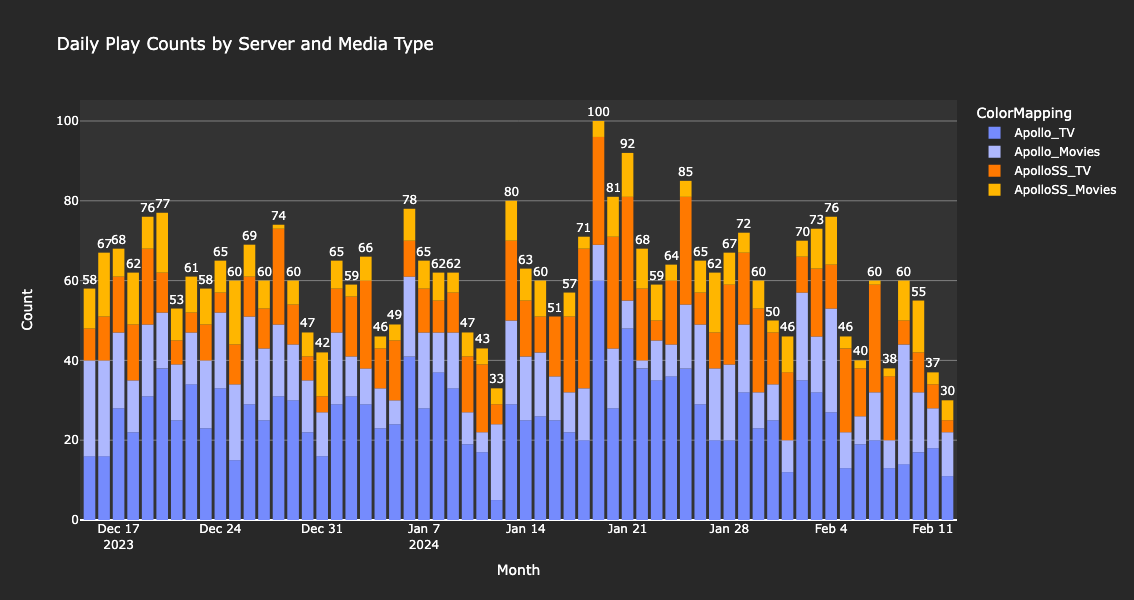

In [53]:
#input variables defined from widget
apikey_serverA = apikey_serverA_w.value
apikey_serverB = apikey_serverB_w.value
servA_ip = servA_ip_w.value
servB_ip = servB_ip_w.value
server_A_name = server_A_name_w.value
server_B_name = server_B_name_w.value

#-------------alternative way to define variables--------------------------------
#apikey_serverA = 'xxxx' #tatuilli API Key
#apikey_serverB = 'xxxx'
#servA_ip = '192.168.1.xxx:8185' #tatuilli Server IP Address
#servB_ip = '192.168.1.xxx:8195'
#server_A_name = 'serverA' #create a name for each server
#server_B_name = 'ServerB'

#Get DAILY data from Tautulli
day_response_a = requests.get(f'http://{servA_ip}/api/v2?apikey={apikey_serverA}&cmd=get_plays_by_date&time_range=60')
#print(day_response_a.status_code)
day_response_b = requests.get(f'http://{servB_ip}/api/v2?apikey={apikey_serverB}&cmd=get_plays_by_date&time_range=60')
#print(day_response_b.status_code)

day_data_a = day_response_a.json()
day_data_b = day_response_b.json()

# Extract relevant information
categories = day_data_a['response']['data']['categories']
series = day_data_a['response']['data']['series']

# Create Dataframe for server A
data_list = []
for s in series:
    category_name = s['name']
    data_values = s['data']
    data_dict = {'Server': server_A_name, 'Category': category_name, **dict(zip(categories, data_values))}
    data_list.append(data_dict)

# Create DataFrame
df_a = pd.DataFrame(data_list)

# Extract relevant informationÍÍ
categories = day_data_b['response']['data']['categories']
series = day_data_b['response']['data']['series']

# Create Dataframe for server B
data_list = []
for s in series:
    category_name = s['name']
    data_values = s['data']
    data_dict = {'Server': server_B_name, 'Category': category_name, **dict(zip(categories, data_values))}
    data_list.append(data_dict)

# Create DataFrame
df_b = pd.DataFrame(data_list)

df_combinded = pd.concat([df_a, df_b], ignore_index=True)


# Melt the DataFrame to have a column for each month
df_daily_melted = pd.melt(df_combinded, id_vars=['Server', 'Category'], var_name='Month', value_name='Count')
#remove Music Category
df_daily_melted = df_daily_melted[df_daily_melted['Category'] != 'Music']


#---------------Bar Chart Code-------------------------
custom_colors = {
                 f'{server_A_name}_TV': '#758bfd', # Specify custom colors for each server and media type
                 f'{server_A_name}_Movies': '#aeb8fe',
                 f'{server_B_name}_TV': '#ff7900',
                 f'{server_B_name}_Movies': '#ffb600'
                }  

# Create a new column combining Server and Category for color mapping
df_daily_melted['ColorMapping'] = df_daily_melted['Server'] + '_' + df_daily_melted['Category']

fig_stacked_bar = px.bar(df_daily_melted, x='Month', y='Count', color='ColorMapping',
                         color_discrete_map=custom_colors,
                         title='Stacked Bar Chart with Server and Category Coloring')

# Remove the outline around the bars
fig_stacked_bar.update_traces(marker_line_color='rgba(0,0,0,0)')  # Fully transparent outline

# Calculate the total count for each category and server combination
total_counts = df_daily_melted.groupby(['Month'])['Count'].sum().reset_index()

# Add annotations for total count at the top outside of each bar
annotations = [dict(x=row['Month'], 
                    y=row['Count'],
                    text=row['Count'],
                    showarrow=False,
                    xanchor='center',
                    yanchor='bottom',
                    font=dict(color='white')
                   ) for i, row in total_counts.iterrows()]
fig_stacked_bar.update_layout(annotations=annotations)


# Customize the layout, including the background color
fig_stacked_bar.update_layout(
    plot_bgcolor='#333333',  # Set the background color
    paper_bgcolor='#282828',  # Set the paper color
    title={'text': 'Daily Play Counts by Server and Media Type', 'font': {'color': 'white'}},  # Set title text and color
    xaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white'))),  # Set x-axis tick label and title text color
    yaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white')), gridcolor='grey'),  # Set y-axis tick label, title text color, and gridline color
    legend=dict(font=dict(color='white')),
    height=600
    
)

# Display the plot
fig_stacked_bar.show()
		

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



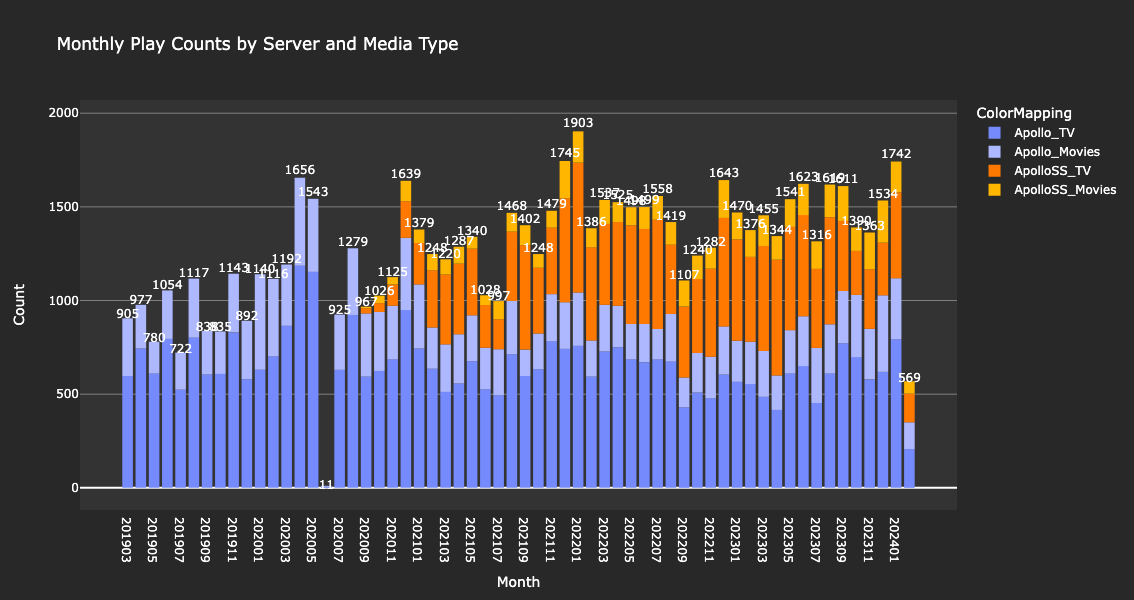

In [54]:
#Monthly

#Get DAILY data from Tautulli
month_response_a = requests.get(f'http://{servA_ip}/api/v2?apikey={apikey_serverA}&cmd=get_plays_per_month&time_range=60')
#print(month_response_a.status_code)
month_response_b = requests.get(f'http://{servB_ip}/api/v2?apikey={apikey_serverB}&cmd=get_plays_per_month&time_range=60')
#print(month_response_b.status_code)

month_data_a = month_response_a.json()
month_data_b = month_response_b.json()

# Extract relevant information
categories = month_data_a['response']['data']['categories']
series = month_data_a['response']['data']['series']

# Create Dataframe for server A
data_list = []
for s in series:
    category_name = s['name']
    data_values = s['data']
    data_dict = {'Server': server_A_name, 'Category': category_name, **dict(zip(categories, data_values))}
    data_list.append(data_dict)

# Create DataFrame
df_month_a = pd.DataFrame(data_list)

# Extract relevant informationÍÍ
categories = month_data_b['response']['data']['categories']
series = month_data_b['response']['data']['series']

# Create Dataframe for server B
data_list = []
for s in series:
    category_name = s['name']
    data_values = s['data']
    data_dict = {'Server': server_B_name, 'Category': category_name, **dict(zip(categories, data_values))}
    data_list.append(data_dict)

# Create DataFrame
df_month_b = pd.DataFrame(data_list)

df_combinded_month = pd.concat([df_month_a, df_month_b], ignore_index=True)


# Melt the DataFrame to have a column for each month
df_daily_melted_month = pd.melt(df_combinded_month, id_vars=['Server', 'Category'], var_name='Month', value_name='Count')
#Remove Music Category
df_daily_melted_month = df_daily_melted_month[df_daily_melted_month['Category'] != 'Music']


# Convert 'Month' to datetime format
df_daily_melted_month['Month'] = pd.to_datetime(df_daily_melted_month['Month'], format='%b %Y')


# Reformat 'Month' to YYYYMM
df_daily_melted_month['Month'] = df_daily_melted_month['Month'].dt.strftime('%Y%m')



#---------------Bar Chart Code-------------------------
custom_colors = {
                 f'{server_A_name}_TV': '#758bfd', # Specify custom colors for each server and media type
                 f'{server_A_name}_Movies': '#aeb8fe',
                 f'{server_B_name}_TV': '#ff7900',
                 f'{server_B_name}_Movies': '#ffb600'
                }  

# Create a new column combining Server and Category for color mapping
df_daily_melted_month['ColorMapping'] = df_daily_melted_month['Server'] + '_' + df_daily_melted_month['Category']

fig_stacked_bar_month = px.bar(df_daily_melted_month, x='Month', y='Count', color='ColorMapping',
                         color_discrete_map=custom_colors,
                         title='Stacked Bar Chart with Server and Category Coloring')

# Remove the outline around the bars
fig_stacked_bar_month.update_traces(marker_line_color='rgba(0,0,0,0)')  # Fully transparent outline

# Calculate the total count for each category and server combination
total_counts_month = df_daily_melted_month.groupby(['Month'])['Count'].sum().reset_index()

# Add annotations for total count at the top outside of each bar
annotations_trace = px.scatter(total_counts_month,
                               x='Month',
                               y=1.02 * total_counts_month['Count'],
                               text='Count',
                               color_discrete_sequence=['rgba(0,0,0,0)'])

# Add the annotations trace to the bar chart
fig_stacked_bar_month.add_trace(annotations_trace.data[0])
# Customize the appearance of the annotations
fig_stacked_bar_month.update_traces(textfont_color='white')  # Set the text color of annotations



# Customize the layout, including the background color
fig_stacked_bar_month.update_layout(
    plot_bgcolor='#333333',  # Set the background color
    paper_bgcolor='#282828',  # Set the paper color
    title={'text': 'Monthly Play Counts by Server and Media Type', 'font': {'color': 'white'}},  # Set title text and color
    xaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white'))),  # Set x-axis tick label and title text color
    yaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white')), gridcolor='grey'),  # Set y-axis tick label, title text color, and gridline color
    legend=dict(font=dict(color='white')),
    height=600,
    
)

# Display the plot
fig_stacked_bar_month.show()
		
		

In [42]:
#Top Users complete
history_days = 60

def fetch_and_update(history_days):
    # Your existing data retrieval code here
    
    afterdate = datetime.now() - timedelta(days=history_days)
    afterdate_str = afterdate.strftime("%Y-%m-%d")
    user_response_a = requests.get(f'http://{servA_ip}/api/v2?apikey={apikey_serverA}&cmd=get_history&after={afterdate_str}&length=4000')
    user_response_b = requests.get(f'http://{servB_ip}/api/v2?apikey={apikey_serverB}&cmd=get_history&after={afterdate_str}&length=4000')
    user_data_a = user_response_a.json()
    user_data_b = user_response_b.json()


    # Extract relevant information
    records = user_data_a['response']['data']['data']
    global df_combinded_user, fig_stacked_bar_user 
    # Create a DataFrame
    df_user_a = pd.DataFrame(records, columns=["date", "user", "media_type", "full_title", "grandparent_title", "ip_address"])
    df_user_a['Server'] = server_A_name
    
    # Extract relevant information
    records = user_data_b['response']['data']['data']
    
    # Create a DataFrame
    df_user_b = pd.DataFrame(records, columns=["date", "user", "media_type", "full_title", "grandparent_title", "ip_address"])
    df_user_b['Server'] = server_B_name
    
    df_combinded_user = pd.concat([df_user_a, df_user_b], ignore_index=True)
    df_combinded_user = df_combinded_user.drop_duplicates()
    
    # Assuming df is your DataFrame and 'date' is the Unix timestamp column
    df_combinded_user['date'] = pd.to_datetime(df_combinded_user['date'], unit='s')  # Convert Unix timestamp to datetime
    
    # Convert to Pacific Standard Time (PST)
    df_combinded_user['date_pst'] = df_combinded_user['date'].dt.tz_localize(timezone.utc).dt.tz_convert('America/Los_Angeles')
    
    # Extract date in the format "YYYY-MM-DD"
    df_combinded_user['date_pt'] = df_combinded_user['date_pst'].dt.strftime('%Y-%m-%d')
    df_combinded_user.rename(columns={'date': 'date_time'}, inplace=True)
    df_combinded_user.drop(columns=['date_pst', 'date_time'], inplace=True)
    df_combinded_user['count'] = 1
    df_combinded_user['media_type'] = df_combinded_user['media_type'].replace('episode', 'TV')
    
    # Group by 'user', 'media_type', and 'server', and sum the 'count'
    grouped_user_df = df_combinded_user.groupby(['user'])['count'].sum().reset_index()
    grouped_user_df = grouped_user_df.sort_values(by='count', ascending=False)
    grouped_user_df = grouped_user_df.head(20)
    # Melt the DataFrame to have a column for each user
    #df_melted_user = pd.melt(df_combinded_user, id_vars=['Server', 'Category'], var_name='User', value_name='Count')
    #df_melted_user = df_melted_user[df_melted_user['Category'] != 'Music']
    
    #graph code:
    # Assuming df_daily_melted contains the necessary data

    
    fig_stacked_bar_user = px.bar(
    grouped_user_df,
    y='count',
    x='user',
    color="count",
    color_continuous_scale="oryel",
    title='Stacked Bar Chart with Server and Category Coloring',
    text='count',  # Set the 'count' as text for data labels
    )

    fig_stacked_bar_user.update_traces(
    textposition='outside',  # Position data labels outside the bars
    textfont_color='white',
    textfont_size=18 # Set the color of the data labels to white
    )

    # Remove the outline around the bars
    fig_stacked_bar_user.update_traces(marker_line_color='rgba(0,0,0,0)')  # Fully transparent outline
    
    # Calculate the total count for each category and server combination
    total_counts_user = grouped_user_df.groupby(['user'])['count'].sum().reset_index()
    
    
    # Customize the layout, including the background color
    fig_stacked_bar_user.update_layout(
        plot_bgcolor='#333333',  # Set the background color to white
        paper_bgcolor='#282828',  # Set the paper color to white
        title={'text': f'Number of Plays by User - {history_days} days', 'font': {'color': 'white'}},  # Set title text and color
        xaxis=dict(
            tickfont=dict(size=15, color='white'), 
            title=dict(font=dict(color='white'))),  # Set x-axis tick label and title text color
        yaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white')), gridcolor='grey'),  # Set y-axis tick label, title text color, and gridline color
        legend=dict(font=dict(color='white')),
        height=700
        #colorbar_title_font_color='white'
        #coloraxis_colorbar=dict(font=dict(color='white'))
        
    )
    # Return the figure object
    return fig_stacked_bar_user

    # Display the plot
    fig_stacked_bar_user.show()
		
# Create an interactive IntSlider widget
history_days_slider = widgets.IntSlider(
    value=history_days,
    min=1,
    max=365,  # Set your preferred maximum value
    step=1,
    description='Days:',
    continuous_update=False
)

# Use interact to connect the widget with the function
widgets.interact(fetch_and_update, history_days=history_days_slider)

# Display the slider
display(history_days_slider)

interactive(children=(IntSlider(value=60, continuous_update=False, description='Days:', max=365, min=1), Outpu…

IntSlider(value=60, continuous_update=False, description='Days:', max=365, min=1)

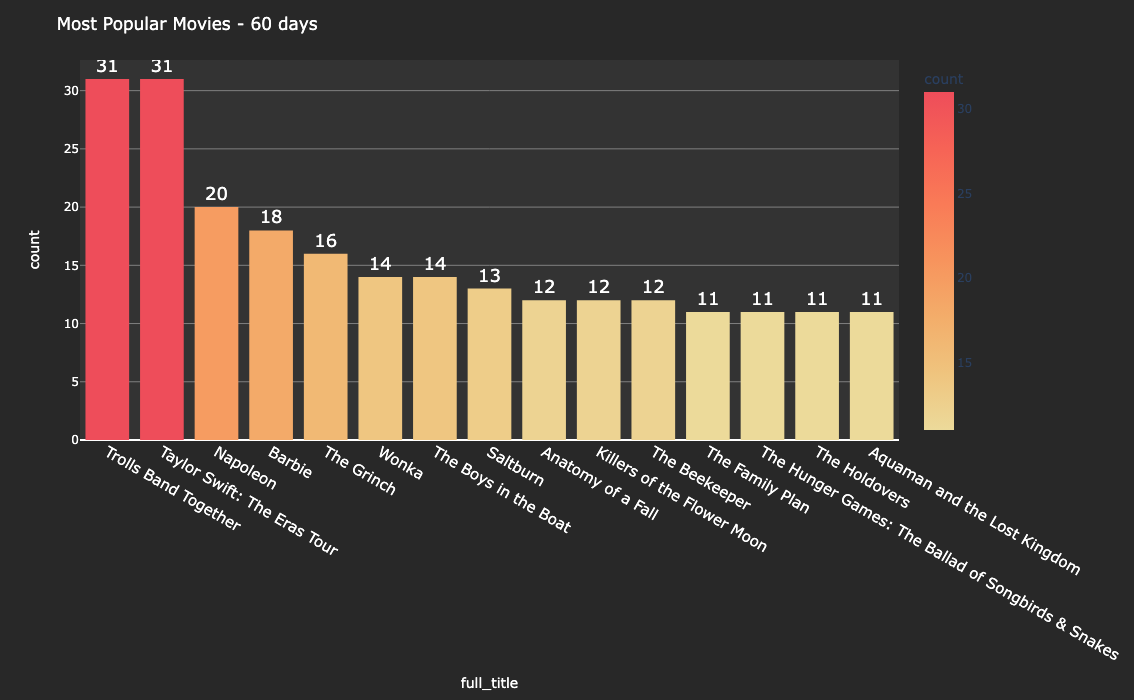

In [43]:
#Top Movies complete

grouped_movie_df = df_combinded_user
grouped_movie_df = grouped_movie_df.drop_duplicates()

# Group by 'user', 'media_type', and 'server', and sum the 'count'
grouped_movie_df = grouped_movie_df[grouped_movie_df['media_type'] == 'movie']
grouped_movie_df = grouped_movie_df.groupby(['full_title'])['count'].sum().reset_index()
grouped_movie_df = grouped_movie_df.sort_values(by='count', ascending=False)
grouped_movie_df = grouped_movie_df.head(15)
# Melt the DataFrame to have a column for each user
#df_melted_movie = pd.melt(df_combinded_movie, id_vars=['Server', 'Category'], var_name='User', value_name='Count')
#df_melted_movie = df_melted_movie[df_melted_movie['Category'] != 'Music']

#graph code:
# Assuming df_daily_melted contains the necessary data

fig_stacked_bar_movie = px.bar(
    grouped_movie_df, 
    y='count', 
    x='full_title', 
    color="count",  # Use 'count' for continuous color scale
    color_continuous_scale="oryel",  # Set the continuous color scale
    text="count"
)

fig_stacked_bar_movie.update_traces(
    textposition='outside',  # Position data labels outside the bars
    textfont_color='white',
    textfont_size=18 # Set the color of the data labels to white
    )

# Remove the outline around the bars
fig_stacked_bar_movie.update_traces(marker_line_color='rgba(0,0,0,0)')  # Fully transparent outline

# Calculate the total count for each category and server combination
total_counts_movie = grouped_movie_df.groupby(['full_title'])['count'].sum().reset_index()


# Customize the layout, including the background color
fig_stacked_bar_movie.update_layout(
    plot_bgcolor='#333333',  # Set the background color to white
    paper_bgcolor='#282828',  # Set the paper color to white
    title={'text': f'Most Popular Movies - {history_days} days', 'font': {'color': 'white'}},  # Set title text and color
    xaxis=dict(
        tickfont=dict(size=15, color='white'),
        title=dict(font=dict(color='white'))),  # Set x-axis tick label and title text color
    yaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white')), gridcolor='grey'),  # Set y-axis tick label, title text color, and gridline color
    legend=dict(font=dict(color='white')),
     #margin=dict(t=25),
    height=700
    #colorbar_title_font_color='white'
    #coloraxis_colorbar=dict(font=dict(color='white'))
    
)





# Display the plot
fig_stacked_bar_movie.show()

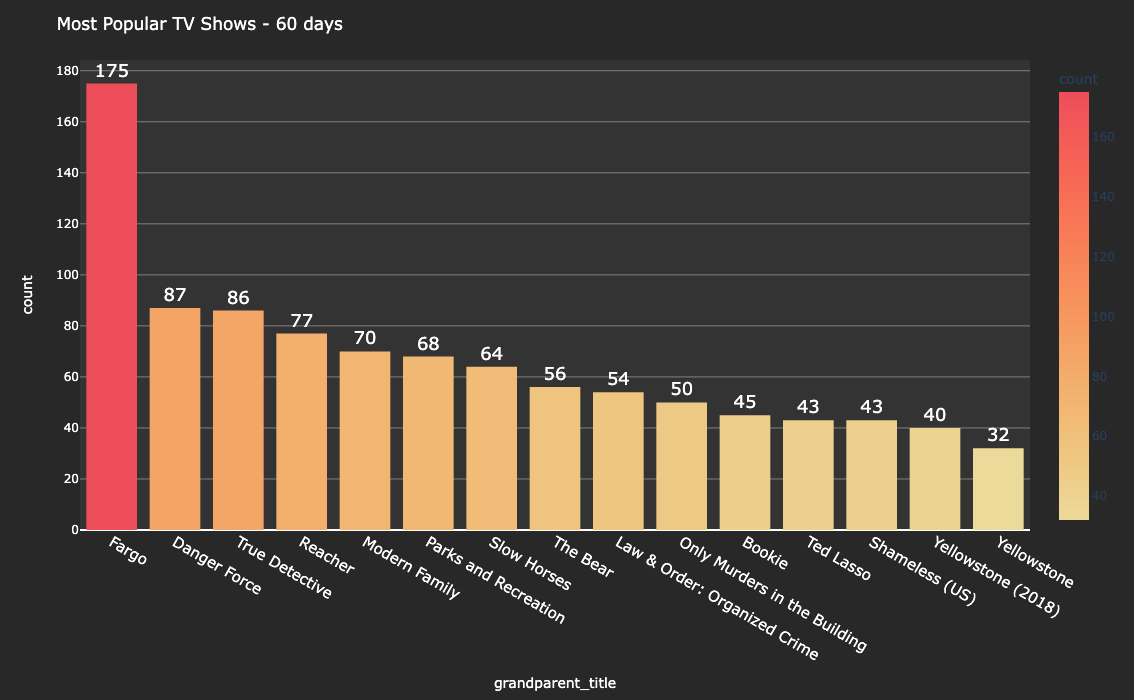

In [44]:
#Top TV complete

grouped_tv_df = df_combinded_user
grouped_tv_df = grouped_tv_df.drop_duplicates()

# Group by 'user', 'media_type', and 'server', and sum the 'count'
grouped_tv_df = grouped_tv_df[grouped_tv_df['media_type'] == 'TV']
grouped_tv_df = grouped_tv_df.groupby(['grandparent_title'])['count'].sum().reset_index()
grouped_tv_df = grouped_tv_df.sort_values(by='count', ascending=False)
grouped_tv_df = grouped_tv_df.head(15)
# Melt the DataFrame to have a column for each user
#df_melted_tv = pd.melt(df_combinded_tv, id_vars=['Server', 'Category'], var_name='User', value_name='Count')
#df_melted_tv = df_melted_tv[df_melted_tv['Category'] != 'Music']

#graph code:
# Assuming df_daily_melted contains the necessary data

fig_stacked_bar_tv = px.bar(
    grouped_tv_df, 
    y='count', 
    x='grandparent_title', 
    color="count",  # Use 'count' for continuous color scale
    color_continuous_scale="oryel",  # Set the continuous color scale
    text="count"
)

fig_stacked_bar_tv.update_traces(
    textposition='outside',  # Position data labels outside the bars
    textfont_color='white',
    textfont_size=18 # Set the color of the data labels to white
    )

# Remove the outline around the bars
fig_stacked_bar_tv.update_traces(marker_line_color='rgba(0,0,0,0)')  # Fully transparent outline

# Calculate the total count for each category and server combination
total_counts_tv = grouped_tv_df.groupby(['grandparent_title'])['count'].sum().reset_index()


# Customize the layout, including the background color
fig_stacked_bar_tv.update_layout(
    plot_bgcolor='#333333',  # Set the background color to white
    paper_bgcolor='#282828',  # Set the paper color to white
    title={'text': f'Most Popular TV Shows - {history_days} days', 'font': {'color': 'white'}},  # Set title text and color
    xaxis=dict(
        tickfont=dict(size=15, color='white'),
        title=dict(font=dict(color='white'))),  # Set x-axis tick label and title text color
    yaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white')), gridcolor='grey'),  # Set y-axis tick label, title text color, and gridline color
    legend=dict(font=dict(color='white')),
    height=700
    #colorbar_title_font_color='white'
    #coloraxis_colorbar=dict(font=dict(color='white'))
    
)

# Display the plot
fig_stacked_bar_tv.show()

In [45]:
#Detailed Watch History
# Your existing data retrieval code here
pd.set_option('display.max_rows', None)


def display_table(hist_limit, selected_user, selected_title):
    global outputdf
    outputdf = df_combinded_user.drop_duplicates()
    column_order = ['date_pt', 'Server', 'user','ip_address', 'media_type', 'full_title', 'grandparent_title', 'count']
    outputdf = outputdf[column_order]

    # Apply user filter
    if selected_user != 'All Users':
        outputdf = outputdf[outputdf['user'] == selected_user]

    # Apply title filter
    if selected_title != 'All Titles':
        outputdf = outputdf[outputdf['full_title'] == selected_title]

    outputdf['full_title'] = outputdf['full_title'].str.slice(0,60)
    outputdf.sort_values(by=['date_pt', 'user', 'ip_address'], ascending=[False, True, True], inplace=True)
    outputdf = outputdf.head(hist_limit)
    drop_columns = ['count']
    outputdf.drop(columns=drop_columns, inplace=True)
    outputdf.rename(columns={'full_title': 'title', 'grandparent_title': 'show'}, inplace=True)
    table = tabulate(outputdf, headers='keys', tablefmt='pretty', showindex=False, colalign=('left',) * len(outputdf.columns))
    outputdf_format = outputdf.style.set_properties(**{'text-align': 'left'})
    #print(table)
    display(outputdf_format)

# Create an interactive widget for the number of rows
hist_limit_widget = widgets.IntSlider(
    value=100,
    min=1,
    max=2000,
    step=10,
    description='Rows:',
    continuous_update=False
)

# Create a dropdown widget for user selection (sorted alphabetically)
users_list = ['All Users'] + sorted(list(df_combinded_user['user'].unique()))
user_dropdown_widget = widgets.Dropdown(
    options=users_list,
    value='All Users',
    description='Select User:',
)

# Create a dropdown widget for title selection (sorted alphabetically)
titles_list = ['All Titles'] + sorted(list(df_combinded_user['full_title'].unique()))
title_dropdown_widget = widgets.Dropdown(
    options=titles_list,
    value='All Titles',
    description='Select Title:',
)

# Use interact to connect all widgets with the function
widgets.interact(display_table, hist_limit=hist_limit_widget, selected_user=user_dropdown_widget, selected_title=title_dropdown_widget)


interactive(children=(IntSlider(value=100, continuous_update=False, description='Rows:', max=2000, min=1, step…

<function __main__.display_table(hist_limit, selected_user, selected_title)>

  Category  Count  Percentage
0   Movies   1284    35.02455
1       TV   2382    64.97545


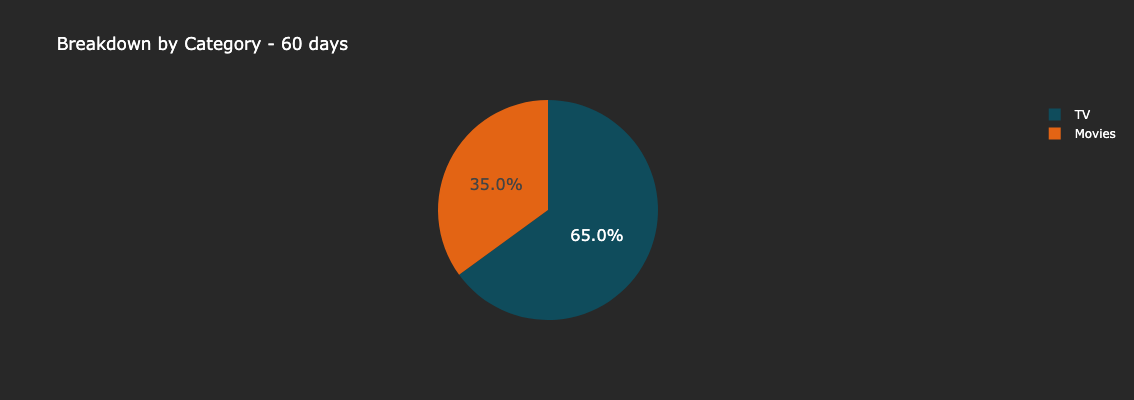

In [46]:
df_category = df_daily_melted.groupby(['Category'])['Count'].sum().reset_index()


# Calculate percentages
df_category['Percentage'] = df_category['Count'] / df_category['Count'].sum() * 100


# Create a pie chart with percentages
custom_colors = {
    'TV': '#0f4c5c',
    'Movies': '#e36414',
}
# Create a pie chart with percentages

fig_pie = px.pie(df_category, values='Count', names='Category', 
             color='Category',
             title='Category Distribution by Server',
             color_discrete_map=custom_colors,
             labels={'Percentage': 'Percentage (%)'})
print(df_category)

fig_pie.update_layout(
    plot_bgcolor='#333333',  # Set the background 
    paper_bgcolor='#282828',  # Set the paper 
    title={'text': f'Breakdown by Category - {history_days} days', 'font': {'color': 'white'}},  # Set title text and color
    xaxis=dict(
        tickfont=dict(size=15, color='white'),
        title=dict(font=dict(color='white'))),  # Set x-axis tick label and title text color
    yaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white')), gridcolor='grey'),  # Set y-axis tick label, title text color, and gridline color
    legend=dict(font=dict(color='white')),
    height=400
)

fig_pie.update_traces(texttemplate='%{percent:.1%}', textposition='inside', textfont_size=16)
# Show the pie chart
fig_pie.show()


     Server  Count  Percentage
0    Apollo   2412   65.793781
1  ApolloSS   1254   34.206219


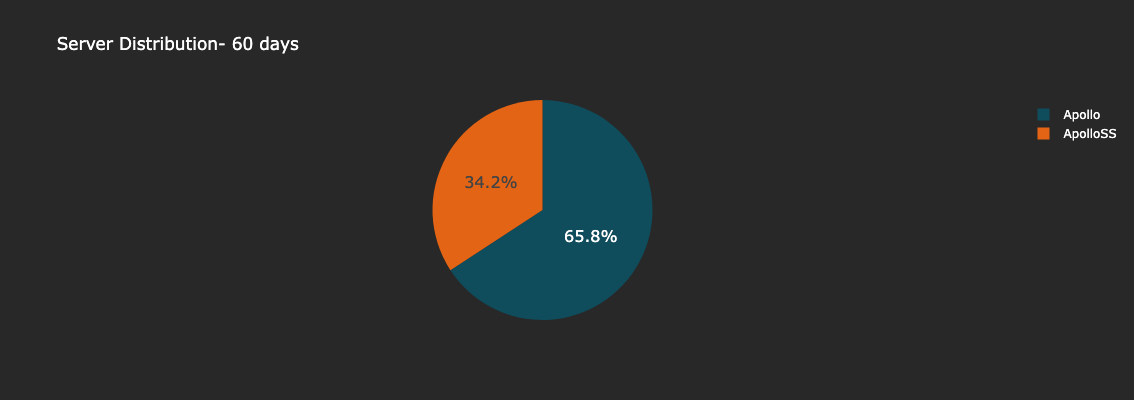

In [47]:
df_server = df_daily_melted.groupby(['Server'])['Count'].sum().reset_index()


# Calculate percentages
df_server['Percentage'] = df_server['Count'] / df_server['Count'].sum() * 100

print(df_server)
# Create a pie chart with percentages
custom_colors = {
    'Apollo': '#0f4c5c',
    'ApolloSS': '#e36414',
}

serv_pie = px.pie(df_server, 
             values='Count', 
             names='Server', 
             color='Server',
             title='Category Distribution by Server',
             color_discrete_map=custom_colors,
             labels={'Percentage': 'Percentage (%)'})


serv_pie.update_layout(
    plot_bgcolor='#333333',  # Set the background 
    paper_bgcolor='#282828',  # Set the paper
    title={'text': f'Server Distribution- {history_days} days', 'font': {'color': 'white'}},  # Set title text and color
    xaxis=dict(
        tickfont=dict(size=15, color='white'),
        title=dict(font=dict(color='white'))),  # Set x-axis tick label and title text color
    yaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white')), gridcolor='grey'),  # Set y-axis tick label, title text color, and gridline color
    legend=dict(font=dict(color='white')),
    height=400
)

serv_pie.update_traces(texttemplate='%{percent:.1%}', textposition='inside', textfont_size=16)


# Show the pie chart
serv_pie.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



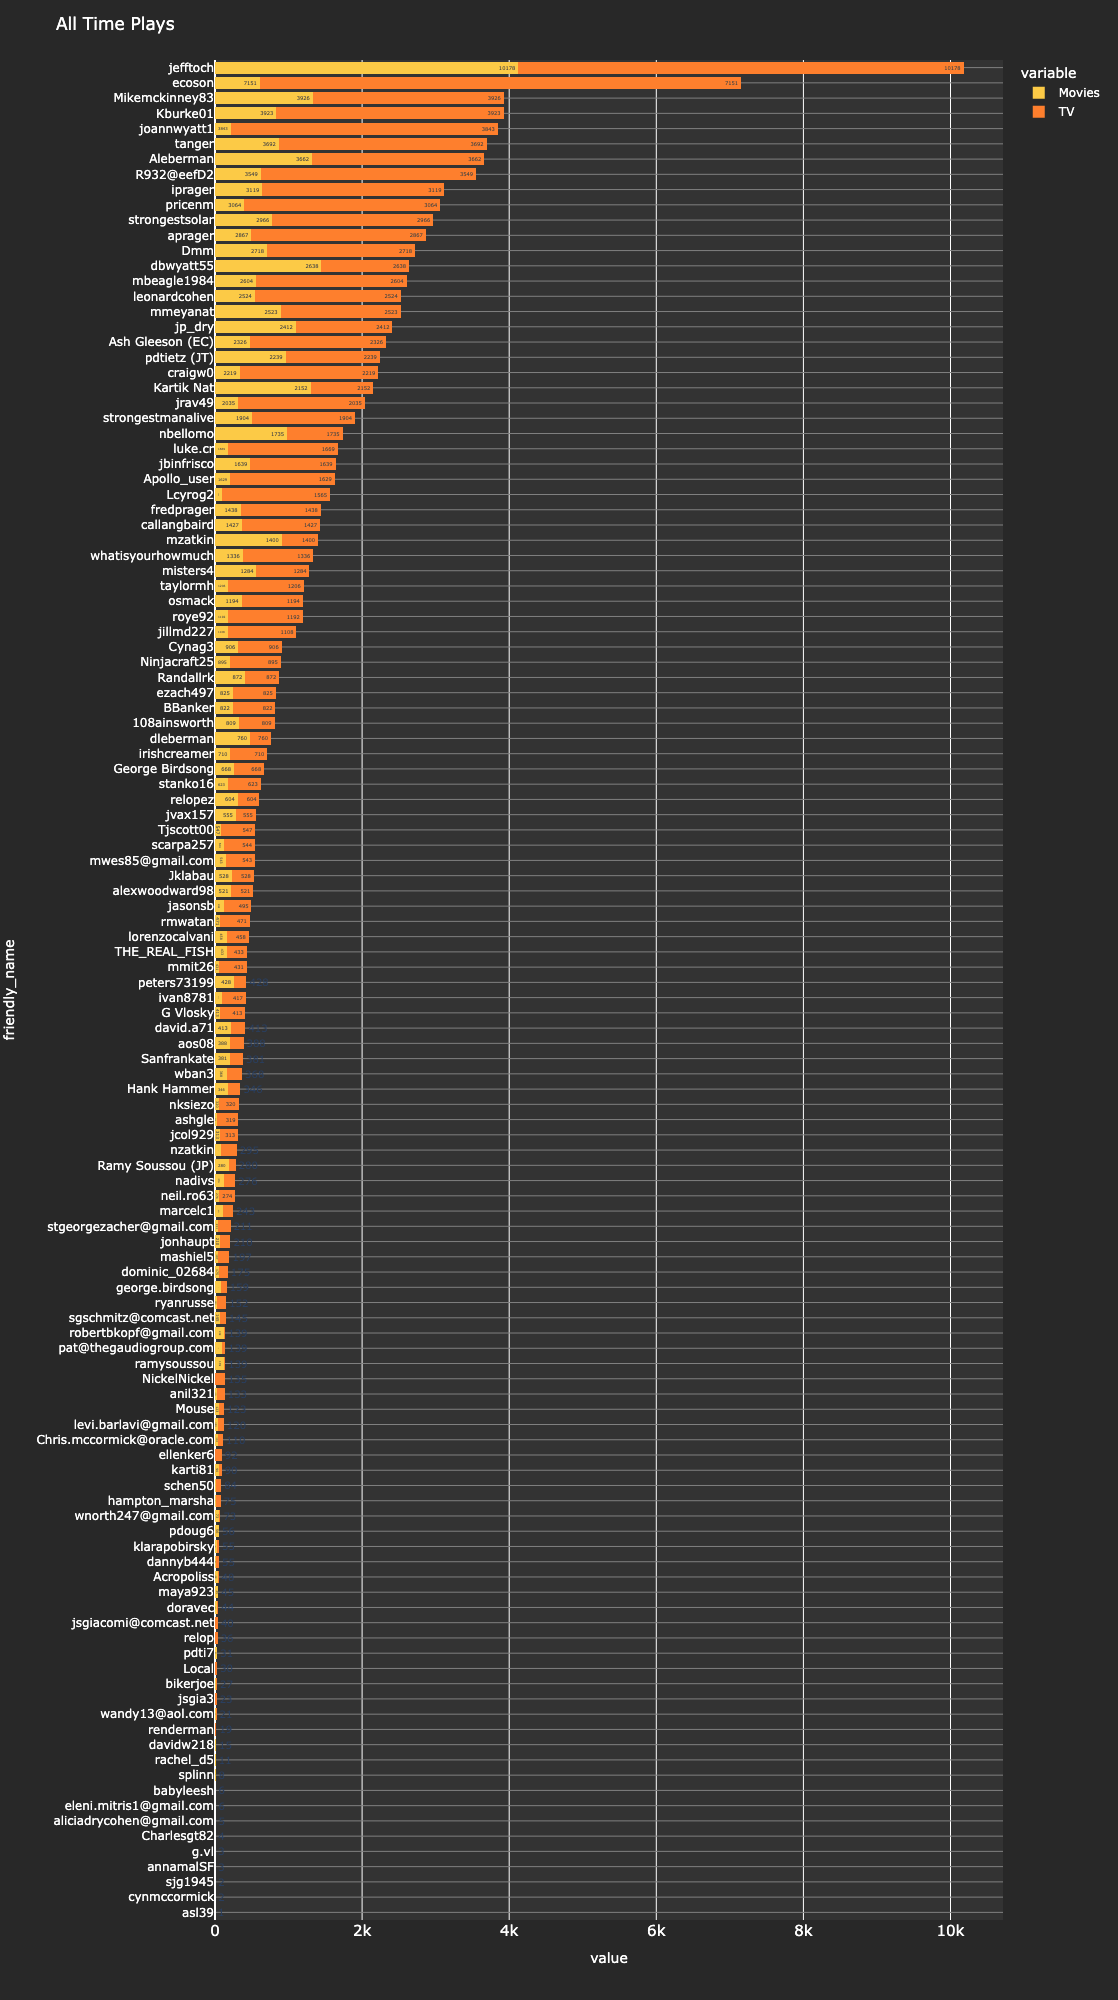

In [48]:
#Get all time plays for Movies and TV shows

#Get DAILY data from Tautulli 1=movies 2=shows
all_time_movie_response_a = requests.get(f'http://{servA_ip}/api/v2?apikey={apikey_serverA}&cmd=get_library_user_stats&section_id=1')
#print(all_time_movie_response_a.status_code) 1= shows 2=movies
all_time_movie_response_b = requests.get(f'http://{servB_ip}/api/v2?apikey={apikey_serverB}&cmd=get_library_user_stats&section_id=2')
#print(all_time_movie_response_b.status_code)

all_time_movie_data_a = all_time_movie_response_a.json()
all_time_movie_data_b = all_time_movie_response_b.json()

user_info_list_a = [
    {"friendly_name": user["friendly_name"], "total_plays": user["total_plays"]}
    for user in all_time_movie_data_a["response"]["data"]
]

# Create DataFrame from the list
df_user_info_a = pd.DataFrame(user_info_list_a)

user_info_list_b = [
    {"friendly_name": user["friendly_name"], "total_plays": user["total_plays"]}
    for user in all_time_movie_data_b["response"]["data"]
]

# Create DataFrame from the list
df_user_info_b = pd.DataFrame(user_info_list_b)


df_combinded_all_time_movie = pd.concat([df_user_info_a, df_user_info_b], ignore_index=True)
df_combinded_all_time_movie['media_type'] = 'Movies'
df_combinded_all_time_movie = df_combinded_all_time_movie.groupby(['friendly_name', 'media_type'])['total_plays'].sum().reset_index()
df_combinded_all_time_movie.sort_values(by='total_plays', ascending=False, inplace=True)

#---------------------------tv section---------------------------------

#Get DAILY data from Tautulli 1=movies 2=shows
all_time_tv_response_a = requests.get(f'http://{servA_ip}/api/v2?apikey={apikey_serverA}&cmd=get_library_user_stats&section_id=2')
#print(all_time_tv_response_a.status_code) 1= shows 2=movies
all_time_tv_response_b = requests.get(f'http://{servB_ip}/api/v2?apikey={apikey_serverB}&cmd=get_library_user_stats&section_id=1')
#print(all_time_tv_response_b.status_code)

all_time_tv_data_a = all_time_tv_response_a.json()
all_time_tv_data_b = all_time_tv_response_b.json()

user_info_list_a = [
    {"friendly_name": user["friendly_name"], "total_plays": user["total_plays"]}
    for user in all_time_tv_data_a["response"]["data"]
]

# Create DataFrame from the list
df_user_info_a = pd.DataFrame(user_info_list_a)

user_info_list_b = [
    {"friendly_name": user["friendly_name"], "total_plays": user["total_plays"]}
    for user in all_time_tv_data_b["response"]["data"]
]

# Create DataFrame from the list
df_user_info_b = pd.DataFrame(user_info_list_b)


df_combinded_all_time_tv = pd.concat([df_user_info_a, df_user_info_b], ignore_index=True)
df_combinded_all_time_tv['media_type'] = 'TV'
df_combinded_all_time_tv = df_combinded_all_time_tv.groupby(['friendly_name', 'media_type'])['total_plays'].sum().reset_index()
df_combinded_all_time_tv.sort_values(by='total_plays', ascending=False, inplace=True)

df_combined_total = pd.concat([df_combinded_all_time_tv, df_combinded_all_time_movie], ignore_index=True)
df_combined_total.sort_values(by=['media_type','total_plays'], ascending=[False, False], inplace=True)
df_combined_pivoted = df_combined_total.pivot_table(index='friendly_name', columns='media_type', values='total_plays', fill_value=0)
df_combined_pivoted['combined_plays'] = df_combined_pivoted['Movies'] + df_combined_pivoted['TV']
df_combined_pivoted.sort_values(by='combined_plays', ascending=True , inplace=True)


custom_colors = {'Movies': '#fcca46','TV': '#fe7f2d'}  # Specify custom colors for each server

Stacked_bar_all_time = px.bar(
    df_combined_pivoted, 
    x=['Movies','TV'], 
    y=df_combined_pivoted.index,
    color_discrete_map=custom_colors,
    barmode='stack',
    text=df_combined_pivoted['combined_plays']
    
)

# Remove the outline around the bars
Stacked_bar_all_time.update_traces(marker_line_color='rgba(0,0,0,0)')  # Fully transparent outline

# Customize the layout, including the background color
Stacked_bar_all_time.update_layout(
    plot_bgcolor='#333333',  # Set the background color to white
    paper_bgcolor='#282828',  # Set the paper color to white
    title={'text': 'All Time Plays', 'font': {'color': 'white'}},  # Set title text and color
    xaxis=dict(
        tickfont=dict(size=15, color='white'),
        title=dict(font=dict(color='white'))),  # Set x-axis tick label and title text color
    yaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white')), gridcolor='grey'),  # Set y-axis tick label, title text color, and gridline color
    legend=dict(font=dict(color='white')),
    height=2000
)
# Add annotations for grand total outside the bar

Stacked_bar_all_time.show()


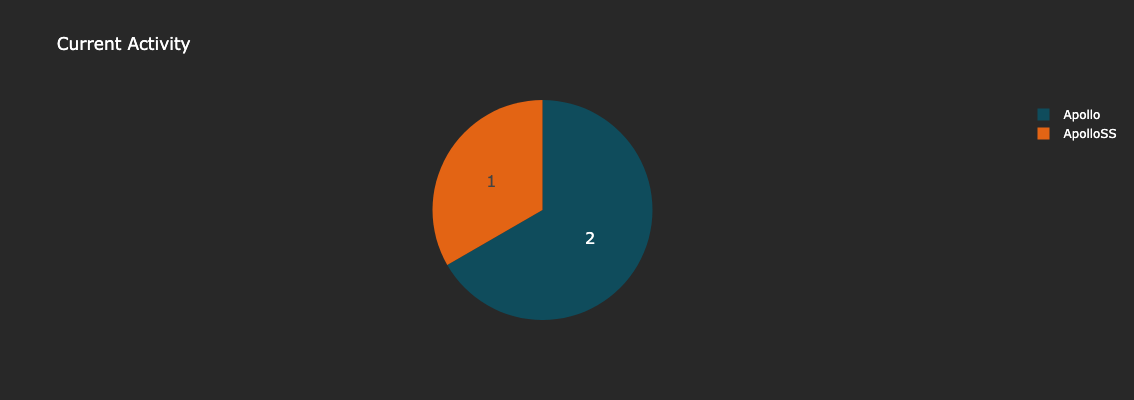

     server  count
0    Apollo      2
1  ApolloSS      1
  stream_count media_type      user     ip_address  \
0            2    episode   pricenm    73.71.59.43   
1            2      movie  ezach497  73.70.155.204   
2            1    episode    ecoson  47.154.21.118   

                                          full_title    server  count  
0       Billions - The Man in the Olive Drab T-Shirt    Apollo      1  
1  The Hunger Games: The Ballad of Songbirds & Sn...    Apollo      1  
2             True Detective - Night Country: Part 5  ApolloSS      1  


,stream_count,media_type,user,ip_address,full_title,server,count
0,2,episode,pricenm,73.71.59.43,Billions - The Man in the Olive Drab T-Shirt,Apollo,1
1,2,movie,ezach497,73.70.155.204,The Hunger Games: The Ballad of Songbirds & Sn...,Apollo,1
2,1,episode,ecoson,47.154.21.118,True Detective - Night Country: Part 5,ApolloSS,1


In [49]:
#Get Activity
activity_response_a = requests.get(f'http://{servA_ip}/api/v2?apikey={apikey_serverA}&cmd=get_activity')
#print(activity_response_a.status_code)
activity_response_b = requests.get(f'http://{servB_ip}/api/v2?apikey={apikey_serverB}&cmd=get_activity')
#print(activity_response_b.status_code)

activity_data_a = activity_response_a.json()
activity_data_b = activity_response_b.json()
#print(activity_data_a)
#print(activity_data_b)

# Extract stream_count, media_type, and title from the JSON
stream_count = activity_data_a["response"]["data"]["stream_count"]
sessions_data = activity_data_a["response"]["data"]["sessions"]

# Create a list of dictionaries with required information
activity_list_a = [{"stream_count": stream_count, "media_type": session["media_type"],"user": session["user"],"ip_address": session["ip_address"], "full_title": session["full_title"]} for session in sessions_data]

df_activity_list_a = pd.DataFrame(activity_list_a)
df_activity_list_a['server'] = server_A_name
df_activity_list_a['count'] = 1
#print(df_activity_list_a)

# Extract stream_count, media_type, and title from the JSON
stream_count_b = activity_data_b["response"]["data"]["stream_count"]
sessions_data_b = activity_data_b["response"]["data"]["sessions"]

# Create a list of dictionaries with required information
activity_list_b = [{"stream_count": stream_count_b, "media_type": session["media_type"],"user": session["user"],"ip_address": session["ip_address"], "full_title": session["full_title"]} for session in sessions_data_b]

df_activity_list_b = pd.DataFrame(activity_list_b)
df_activity_list_b['server'] = server_B_name
df_activity_list_b['count'] = 1
#print(df_activity_list_b)



df_combined_activity = pd.concat([df_activity_list_a, df_activity_list_b], ignore_index=True)
df_combined_activity.sort_values(by='server', ascending=True, inplace=True)

df_combined_activity_group = df_combined_activity.groupby(['server'])['count'].sum().reset_index()


custom_colors = {
    'Apollo': '#0f4c5c',
    'ApolloSS': '#e36414',
}
active_pie = px.pie(df_combined_activity_group, 
             values='count', 
             names='server', 
             color='server',
             title='Category Distribution by Server',
             color_discrete_map=custom_colors
                   )

active_pie.update_layout(
    plot_bgcolor='#333333',  # Set the background color to white
    paper_bgcolor='#282828',  # Set the paper color to white
    title={'text': f'Current Activity', 'font': {'color': 'white'}},  # Set title text and color
    xaxis=dict(
        tickfont=dict(size=15, color='white'),
        title=dict(font=dict(color='white'))),  # Set x-axis tick label and title text color
    yaxis=dict(tickfont=dict(color='white'), title=dict(font=dict(color='white')), gridcolor='grey'),  # Set y-axis tick label, title text color, and gridline color
    legend=dict(font=dict(color='white')),
    height=400
)

active_pie.update_traces(textinfo='value', textfont_size=16)


active_pie.show()

print(df_combined_activity_group)
print(df_combined_activity)

display(df_combined_activity)


In [50]:
#put dashboards in dashboard
app = dash.Dash(__name__)

app.layout = html.Div(children=[

    html.Div([
        dcc.Graph(id='active_pie', figure=active_pie),
    ], style={'width': '49%', 'display': 'inline-block', 'verticalAlign': 'top'}),

    html.Div([
        dash_table.DataTable(
            id='df_combined_activity',
            columns=[{'name': col, 'id': col} for col in df_combined_activity.columns],
            data=df_combined_activity.to_dict('records'),
            style_table={'backgroundColor': '#333333'},
            style_header={'backgroundColor': '#0f4c5c', 'color': 'white', 'border': '1px solid lightgrey'},
            style_cell={'textAlign': 'left', 'backgroundColor': '#333333', 'color': 'white', 'border': '1px solid lightgrey', 'padding': '5px', 'height': '10px'},
        ),
    ], style={'width': '30%', 'display': 'inline-block', 'verticalAlign': 'top'}),

    html.Div([
        dcc.Graph(id='stacked-bar-month', figure=fig_stacked_bar_month),
    ], style={'width': '100%', 'display': 'inline-block'}),

    html.Div([
        dcc.Graph(id='stacked-bar', figure=fig_stacked_bar),
    ], style={'width': '100%', 'display': 'inline-block'}),

    html.Div([
        dcc.Graph(id='fig_stacked_bar_user', figure=fig_stacked_bar_user),
    ], style={'width': '100%', 'display': 'inline-block'}),
    
    html.Div([
        dcc.Graph(id='fig_stacked_bar_movie', figure=fig_stacked_bar_movie),
    ], style={'width': '100%', 'display': 'inline-block'}),

      html.Div([
        dcc.Graph(id='fig_stacked_bar_tv', figure=fig_stacked_bar_tv),
    ], style={'width': '100%', 'display': 'inline-block'}),
    
    html.Div([
        dcc.Graph(id='fig_pie', figure=fig_pie),
    ], style={'width': '50%', 'display': 'inline-block'}),

    html.Div([
        dcc.Graph(id='serv_pie', figure=serv_pie),
    ], style={'width': '50%', 'display': 'inline-block'}),

    # DataTable
    html.Div([
        dash_table.DataTable(
            id='outputdf',
            #columns=[{'name': col, 'id': col} for col in outputdf.columns],
            columns=[
            {'name': 'date_pt', 'id': 'date_pt', 'width': '30px'},  # Set width of Column 1
            {'name': 'Server', 'id': 'Server', 'width': '50px'},  # Set width of Column 2
            {'name': 'user', 'id': 'user', 'width': '50px'},  # Column 3 width will be automatically adjusted
            {'name': 'ip_address', 'id': 'ip_address', 'width': '30px'},
            {'name': 'media_type', 'id': 'media_type', 'width': '50px'},
            {'name': 'title', 'id': 'title', 'width': '50px'},
            {'name': 'show', 'id': 'show', 'width': '50px'}
            # Add more columns as needed
        ],
            data=outputdf.to_dict('records'),
            style_table={'backgroundColor': '#333333'},  # Set background color of the table
            style_header={'backgroundColor': '#0f4c5c', 'color': 'white', 'border': '1px solid lightgrey'},  # Set header styles
            style_cell={'textAlign': 'left', 'backgroundColor': '#333333', 'color': 'white', 'border': '1px solid lightgrey', 'padding': '5px', 'height': '10px'},  # Set cell styles,
        ),
    ], style={'width': '100%', 'display': 'inline-block'}),
     
    html.Div([
        dcc.Graph(id='Stacked_bar_all_time', figure=Stacked_bar_all_time),
    ], style={'width': '100%', 'display': 'inline-block'})
])


if __name__ == '__main__':
    app.run_server(mode='inline')

In [51]:


print(outputdf)
#display(outputdf)

         date_pt    Server            user       ip_address media_type  \
2089  2024-02-12  ApolloSS     Apollo_user    192.168.200.2         TV   
2090  2024-02-12  ApolloSS     Apollo_user    192.168.200.2         TV   
20    2024-02-12    Apollo        Kburke01     69.42.17.190         TV   
11    2024-02-12    Apollo         Lcyrog2     192.168.3.57      movie   
15    2024-02-12    Apollo    Ninjacraft25   169.199.47.125         TV   
18    2024-02-12    Apollo    Ninjacraft25   169.199.47.125         TV   
2086  2024-02-12  ApolloSS          ecoson    47.154.21.118         TV   
2091  2024-02-12  ApolloSS       ellenker6    71.207.156.16      movie   
0     2024-02-12    Apollo        ezach497    73.70.155.204      movie   
2     2024-02-12    Apollo         iprager    157.131.185.5         TV   
9     2024-02-12    Apollo        jefftoch   75.133.171.175      movie   
12    2024-02-12    Apollo          jp_dry   118.208.109.21      movie   
7     2024-02-12    Apollo          jr